<a href="https://colab.research.google.com/github/dbilic98/DOIAS/blob/master/GAN_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ovaj kod implementira Generative Adversarial Network (GAN) za generiranje moda slika iz skupa podataka Fashion MNIST. Koristi se TensorFlow biblioteka za stvaranje generatora i diskriminatora modela. Treniranje se odvija kroz nekoliko epoha i serija, pri čemu se modeli generatora i diskriminatora treniraju na stvarnim i lažnim podacima. Generirane slike se evaluiraju tj. na temelju rezultata evaluacije može se dobiti informacija o tome koliko dobro model diskriminatora razlikuje stvarne slike od generiranih slika i sprema se model generatora za buduću upotrebu. Na kraju, prikazuju se generirane slike iz GAN-a.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%cd /content/gdrive/My\ Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


# Novi odjeljak
Generator ima ključnu ulogu u generiranju novih podataka koji bi trebali nalikovati stvarnim podacima iz određenog skupa podataka. Generator koristi ulazni šum ili latentni vektor kao ulaz za svoju neuronsku mrežu. Cilj generatora je naučiti transformirati taj latentni vektor u sliku koja je vizualno slična stvarnim slikama.

Generator ima ulazni sloj Dense prima ulazni vektor veličine 100, LeakyReLU sloj  koji dodaje neprekidnost i fleksibilnost modelu, Reshape sloj služi za transformaciju izlaza, i tri Conv2DTranspose sloja za dekonvoluciju slika tj. povećava dimenzije slike koristeći kernel_size 3x3 i strides veličine 2x2. Svaki Conv2DTranspose sloj ima LeakyReLU sloj s parametrom alfa koja kontrolira nagib za negativne vrijednosti, a na kraju je Conv2D sloj s tanh aktivacijom za generiranje izlazne slike. Tanh funkcija pruža neprekidne i glatke prijelaze između vrijednosti piksela, što može rezultirati realističnijim generiranim slikama. Funkcija vraća generator kao model.

In [4]:
def image_generator():
    generator = tf.keras.Sequential()

    generator.add(layers.Dense(256*4*4, input_shape=(100,)))
    generator.add(layers.LeakyReLU())
    generator.add(layers.Reshape((4, 4, 256)))

    generator.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))

    generator.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))

    generator.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))

    generator.add(layers.Conv2D(1, kernel_size=3, padding="same", activation='tanh'))

    return generator

model_generator = image_generator()
model_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                              

Ovaj kod učitava skup slika iz moda Fashion MNIST. Prvo se koristi funkcija load_data() iz biblioteke fashion_mnist za učitavanje skupa podataka, ali samo X_train i Y_train (ulazne slike i oznake). Zatim se filtriraju samo slike koje pripadaju klasi 0 (u ovom slučaju, klasi "T-shirt/top").
Slike se zatim preoblikuju u oblik (28, 28, 1) jer mreža očekuje trodimenzionalni ulaz. Nakon toga, slike se ponovno skaliraju na veličinu (32, 32) koristeći funkciju tf.image.resize().
Sve slike se zatim normaliziraju tako da vrijednosti piksela budu u rasponu od -1 do 1. To se postiže skaliranjem pomoću formule (X - 127.5) / 127.5.
Na kraju, učitani i obradjeni skup slika se sprema u varijablu dataset i ispisuje.

In [5]:
def load_images():
    (X_train, Y_train), (_, _) = fashion_mnist.load_data()

    indices = np.where(Y_train == 0)[0]
    X_train = X_train[indices]

    X_train = X_train.reshape(-1, 28, 28, 1)
    X = []
    for image in X_train:
        resized_image = tf.image.resize(image, (32, 32))
        X.append(resized_image)

    X = np.array(X).astype('float32')
    X = (X - 127.5) / 127.5

    return X

dataset = load_images()
print(dataset.shape)

4422102/4422102 [==============================] - 0s 0us/step
(6000, 32, 32, 1)


Funkcija load_real_data(dataset, n_samples) učitava određeni broj stvarnih podataka. Generira se niz slučajnih indeksa od 0 do broja uzoraka u skupu podataka (dataset.shape[0]) pomoću funkcije np.random.randint(). Iz skupa podataka odabiru se uzorci na temelju generiranih indeksa i dodjeljuju varijabli X. Varijabla y se stvara kao niz jedinica s oblikom (n_samples, 1), što predstavlja oznake za stvarne uzorke. Funkcija vraća učitane uzorke X i njihove odgovarajuće oznake y.

U primjeru koda koristi se funkcija load_real_data(dataset, 100) za učitavanje 100 stvarnih uzoraka podataka iz dataset varijable. Rezultati podataka se pohranjuju u varijable translated_dataset i labels, a zatim se ispisuji.

In [6]:
def load_real_data(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

translated_dataset, labels = load_real_data(dataset, 100)
print(translated_dataset.shape)
print(labels.shape)

(100, 32, 32, 1)
(100, 1)


Funkcija create_fake_data(generator_model, n_samples) generira lažne podatke koristeći model generatora. Generiraju se slučajni ulazni podaci pomoću np.random.randn() s duljinom od 100 * n_samples. Oblik ulaznih podataka se mijenja u (n_samples, 100). Model generatora (generator_model_predict) predviđa lažne podatke na temelju ulaza. Stvara se niz nula oblika (n_samples, 1) kao oznake za lažne podatke. Funkcija vraća generirane lažne podatke X i odgovarajuće oznake y.

create_fake_data(generator_model, 100) za generiranje 100 lažnih uzoraka podataka i ispisivanje.

In [7]:
def create_fake_data(generator_model, n_samples):
    input = np.random.randn(100 * n_samples)
    input = input.reshape(n_samples, 100)
    X = generator_model.predict(input)
    y = np.zeros((n_samples, 1))
    return X, y

translated_dataset, labels = create_fake_data(model_generator, 100)
print(translated_dataset.shape)
print(labels.shape)

4/4 [==============================] - 1s 79ms/step
(100, 32, 32, 1)
(100, 1)


Ovaj kod definira model diskriminatora, koji je neuronska mreža za prepoznavanje i klasifikaciju slika. Cilj mu je razlikovati prave slike od generiranih slika. Arhitektura modela uključuje konvolucijsk sloj Conv2D, LeakyReLU aktivaciju, sloj za ravnanje(Flatten), Dropout sloj i potpuno povezani sloj s sigmoid aktivacijom. Optimizira se s Adam optimizatorom, koristeći binarnu unakrsnu entropiju za gubitak i točnost kao metriku. Pozivom model_discriminator.summary() dobiva se sažetak arhitekture s ukupnim brojem parametara.

Flatten sloj: pretvara višedimenzionalne značajke u vektor. Dropout sloj: ima vjerojatnost odbacivanja od 0.4.kako bi se izbjeglo prenaučenje koda. Dense sloj: je izlazni skloj s jednom jedinicom i aktivacijom sigmoid.

In [8]:
def image_discriminator():
    discriminator = tf.keras.Sequential()
    discriminator.add(layers.Conv2D(64, kernel_size=3, padding="same", input_shape=(32, 32, 1)))
    discriminator.add(layers.LeakyReLU(alpha=0.2))

    discriminator.add(layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"))
    discriminator.add(layers.LeakyReLU(alpha=0.2))

    discriminator.add(layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"))
    discriminator.add(layers.LeakyReLU(alpha=0.2))

    discriminator.add(layers.Conv2D(256, kernel_size=3, strides=(2, 2), padding="same"))
    discriminator.add(layers.LeakyReLU(alpha=0.2))

    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dropout(0.4))
    discriminator.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return discriminator

model_discriminator = image_discriminator()
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

Funkcija create_gan stvara GAN model kombinirajući generator i diskriminator, kako bi generirao nove slike. Generator je odgovoran za generiranje novih slika, dok je diskriminator odgovoran za prepoznavanje pravih slika od generiranih slika.
Postavlja se diskriminator.trainable = False kako bi se onemogućilo treniranje diskriminatora. To je važno jer želimo trenirati samo generator, dok diskriminator koristimo samo za procjenu generiranih slika. Stvara se GAN model kao sekvencki(Sequentual) model dodavanjem generatora i diskriminatora kao slojeva.

Optimizator Adam se koristi za treniranje GAN modela s odgovarajućim postavkama stope učenja. Gubitak se mjeri pomoću binarne unakrsne entropije, jer GAN model nastoji minimizirati razliku između stvarnih i generiranih slika. Na kraju se vraća GAN model. Pozivanjem gan.summary() ispisuje sažetak strukture GAN modela.

In [9]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan = tf.keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)

    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss="binary_crossentropy", optimizer=opt)

    return gan

gan = create_gan(model_discriminator, model_generator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 1)         1005057   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 521345    
                                                                 
Total params: 1,526,402
Trainable params: 1,005,057
Non-trainable params: 521,345
_________________________________________________________________


Ova funkcija se koristi za prikazivanje generiranih slika tijekom treninga GAN modela. Ulazni argument fake_data predstavlja generirane slike koje želimo prikazati. Prvo se slike pretvaraju iz raspona [-1, 1] u raspon [0, 1] kako bi se pravilno prikazale.

Zatim se koristi petlja for koja prolazi kroz prvih 10 generiranih slika. Svaka slika se prikazuje pomoću plt.imshow() funkcije iz biblioteke Matplotlib. Pozivom plt.axis('off') uklanjamo oznake osi kako bismo dobili čist prikaz slike. Stvara se ime datoteke za spremanje svake slike koja se sastoji od epohe treninga i indeksa slike. Slika se sprema u datoteku koristeći plt.savefig() funkciju s nazivom datoteke. Nakon spremanja svake slike, trenutna slika se zatvara pomoću plt.close() funkcije kako bi se oslobodio prostor za prikaz sljedeće slike. Ova funkcija omogućuje spremanje generiranih slika tijekom treninga kako bi se pratio napredak i vizualno prikazao rezultat generacije slika.


In [10]:
def show_generated_images(fake_data, epoch):

    # Pretvori podatke iz [-1,1] u [0,1]
    fake_data = (fake_data + 1) / 2.0

    for i in range(10):
        plt.imshow(fake_data[i])
        plt.axis('off')
        filename = f'{epoch}_generated_image_{i}.png'
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

Funkcija evaluate_and_save se koristi za evaluaciju i spremanje modela generatora. Prihvaća tri ulazna argumenta: model generatora, epohe i polovicu podataka. Prvo, funkcija sprema model generatora u datoteku imenom koje uključuje informaciju o epohi i trenutnom vremenu. Zatim generira nove podatke pozivajući funkcije load_real_data i create_fake_data koristeći model generatora. Nakon toga, evaluira model diskriminatora pozivajući metodu evaluate i računa točnost za stvarne i lažne podatke. Na kraju, ispisuje točnost diskriminatora za stvarne i lažne podatke


In [11]:
def evaluate_and_save(generator_model, epoch, half_dataset):

    # Spremamo model podataka
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    name = f'{epoch}_{now}_generator_model.h5'
    generator_model.save(name)

    # Generiramo nove podatke
    X_real, Y_real = load_real_data(dataset, half_dataset)
    X_fake, Y_fake = create_fake_data(generator_model, half_dataset)

    # Računamo točnost
    _, acc_real = model_discriminator.evaluate(X_real, Y_real)
    _, acc_fake = model_discriminator.evaluate(X_fake, Y_fake)

    print(f'Acc Real: {acc_real * 100}%, Acc Fake: {acc_fake * 100}%')

Funkcija generate_input_data služi za generiranje ulaznih podataka (latentnih vektora). Generira se niz slučajnih brojeva koristeći np.random.randn(100 * n_samples). Veličina niza je određena s (100 * n_samples), što znači da će biti generirano 100 slučajnih brojeva za svaki uzorak.
Nakon toga, niz se preoblikuje u oblik (n_samples, 100) pomoću input_data.reshape(n_samples, 100). Ovdje, n_samples predstavlja broj uzoraka koje želimo generirati.
Generirani ulazni podaci se vraćaju kao rezultat funkcije generate_input_data.


In [12]:
def generate_input_data(n_samples):
    input_data = np.random.randn(100 * n_samples)
    input_data = input_data.reshape(n_samples, 100)
    return input_data

Ovaj kod definira funkciju trening koja prima skup podataka, model generatora, model diskriminatora, broj epoha, veličinu serija (batch size) i početnu epohu kao ulazne parametre.

Tijekom treninga, petlja se izvodi kroz epohe i serije. Za svaku seriju, učitavaju se stvarni podaci, trenira se model diskriminatora s stvarnim podacima, generiraju se lažni podaci pomoću modela generatora, trenira se model diskriminatora s lažnim podacima, generiraju se ulazni podaci za GAN, i trenira se GAN s lažnim podacima. Svake 10 epoha, procjenjuje se i sprema model generatora, te se prikazuju generirane slike. Na kraju se funkcija trening poziva s određenim argumentima kako bi započeo postupak treniranja.

epochs: određuje koliko puta će se cijeli skup podataka (dataset) koristiti za treniranje modela. n_batch: Oodređuje broj uzoraka (sample) koji će se koristiti u svakoj iteraciji treniranja. start: određuje početnu epohu za treniranje modela. Ako je postavljeno start=0, to znači da će treniranje započeti od prve epohe.

U stvarnim primjenama broj epoha i serija treba biti puno veći kako bi se postigla bolja kvaliteta generiranih slika.

In [13]:
def training(data, model_generator, model_discriminator, epochs, n_batch, start=0):
    batch_size = int(data.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Stvorite GAN
    gan = create_gan(model_discriminator, model_generator)

    # Iterirati kroz epohe
    for epoch in range(start, start + epochs):
        # Iteracija kroz serije
        for batch in range(n_batch):
            # Učitaj stvarne podatke
            X_real, Y_real = load_real_data(data, half_batch)

            # Trenirajte diskriminator sa stvarnim podacima
            real_discriminator_cost, _ = model_discriminator.train_on_batch(X_real, Y_real)

            # # Generirajte lažne podatke
            X_fake, Y_fake = create_fake_data(model_generator, half_batch)

            # Trenirajte diskriminator s lažnim podacima
            fake_discriminator_cost, _ = model_discriminator.train_on_batch(X_fake, Y_fake)

            # Generirajte ulazne podatke za GAN
            X_gan = generate_input_data(half_batch)
            Y_gan = np.ones((half_batch, 1))

            # Trenirajte GAN s lažnim podacima
            gan_cost = gan.train_on_batch(X_gan, Y_gan)

        # Prikaz rezultata i troškova svakih 10 epoha
        if (epoch + 1) % 10 == 0:
            evaluate_and_save(model_generator, epoch=epoch, half_dataset=half_batch)
            show_generated_images(X_fake, epoch=epoch)

dataset = load_images()
model_generator = image_generator()
model_discriminator = image_discriminator()


training(dataset, model_generator, model_discriminator, epochs=2, n_batch=64, start=0)
# PREDUGO SE IZVRŠAVA
# training(dataset, model_generator, model_discriminator, epochs=50, n_batch=128, start=0)

1/1 [==============================] - 0s 130ms/step


U ovom kodu se generiraju lažni podaci pomoću generatora modela. Funkcija create_fake_data se koristi kako bi generirala 49 lažnih uzoraka podataka koristeći generator X_fake = X_fake.squeeze(): Upotrebom metode squeeze() uklanjamo dimenziju sa vrijednosti 1 iz X_fake. To je potrebno kako biste mogli pravilno prikazati slike.

Nakon generiranja lažnih podataka, koristi se biblioteka matplotlib.pyplot kako bi se prikazalo 49 generiranih slika. Petlja prolazi kroz svaki od 49 generiranih uzoraka podataka i prikazuje ih koristeći plt.imshow. Prikaz slika je organiziran u mreži veličine 7x7 koristeći plt.subplot. Parametar cmap='gray' označava da se slike trebaju prikazati u sivoj boji. Na kraju, se prikazuje prikupljena slika koristeći plt.show().

2/2 [==============================] - 0s 64ms/step


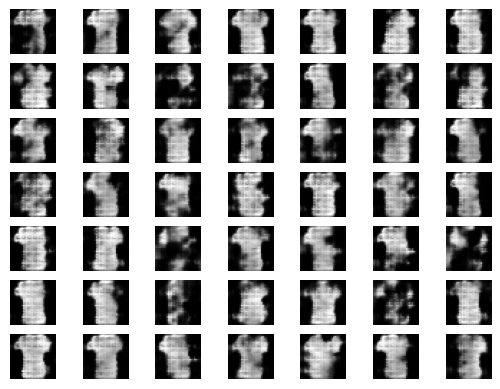

In [14]:
X_fake, _ = create_fake_data(n_samples=49, generator_model=model_generator)
X_fake = X_fake.squeeze()

for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.axis('off')
    plt.imshow(X_fake[i], cmap='gray')

plt.show()